In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from scipy.optimize import approx_fprime
from scipy.differentiate import derivative, jacobian, hessian

import os
import sys
notebook_dir = os.getcwd()
sys.path.insert(0, notebook_dir)

from collections.abc import Callable
from typing import Union
from typehint import NDArray

Array2 = NDArray['2', np.float64]
Array2x2 = NDArray['2,2', np.float64]
ArrayNx2 = NDArray['N,2', np.float64]
Array3 = NDArray['3', np.float64]
Array3x3 = NDArray['3,3', np.float64]
ArrayNx3 = NDArray['N,3', np.float64]

# Q2: Equality Constrained Optimization (25 pts)
In this problem, we are going to use Newton's method to solve some constrained optimization problems. We will start with a smaller problem where we can experiment with Full Newton vs Gauss-Newton, then we will use these methods to solve for the motor torques that make a quadruped balance on one leg.

## Part A (10 pts)
Here we are going to solve some equality-constrained optimization problems with Newton's method. We are given a problem 

$$ \begin{align} \min_x \quad & f(x) \\ 
 \text{st} \quad & c(x) = 0 
 \end{align}$$
 Which has the following Lagrangian:
 $$ \mathcal{L}(x,\lambda) = f(x) + \lambda ^T c(x), $$
and the following KKT conditions for optimality:
$$\begin{align}
\nabla_x \mathcal{L} = \nabla_x f(x) + \bigg[ \frac{\partial c}{\partial x}\bigg] ^T \lambda &= 0 \\ 
c(x) &= 0 
\end{align}$$

Which is just a root-finding problem. To solve this, we are going to solve for a $z = [x^T,\lambda]^T$ that satisfies these KKT conditions.

### Newton's Method with a Linesearch

We use Newton's method to solve for when $r(z) = 0$. To do this, we specify `res_fx(z)` as $r(z)$, and `res_jac_fx(z)` as $\partial r/ \partial z$. To calculate a Newton step, we do the following:

$$\Delta z = -\bigg[ \frac{\partial r}{\partial z} \bigg]^{-1} r(z_k)$$

We then decide the step length with a linesearch that finds the largest $\alpha \leq 1$ such that the following is true:
$$ \phi(z_k + \alpha \Delta z) < \phi(z_k)$$
Where $\phi$ is a "merit function", or `merit_fx(z)` in the code. In this assignment you will use a backtracking linesearch where $\alpha$ is initialized as $\alpha = 1.0$, and is divided by 2 until the above condition is satisfied.

NOTE: YOU DO NOT NEED TO (AND SHOULD NOT) USE A WHILE LOOP ANYWHERE IN THIS ASSIGNMENT. 

In [2]:
def linesearch(
    z: Union[Array2, Array3],
    delta_z: Union[Array2, Array3],
    merit_fx: Callable,
    max_ls_iters: int = 10) -> Union[float, None]:  # optional argument with a default

    # TODO: return maximum α≤1 such that merit_fx(z + α*Δz) < merit_fx(z)
    # with a backtracking linesearch (α = α/2 after each iteration)
    alpha = 1.
    c = 0.5

    # NOTE: DO NOT USE A WHILE LOOP 
    for i in range(max_ls_iters):

        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z)
        if merit_fx(z + alpha*delta_z) < merit_fx(z):
            return alpha

        alpha = alpha*c

    print("linesearch failed")
    

def newtons_method(
    z0: Union[Array2, Array3],
    res_fx: Callable,
    res_jac_fx: Callable,
    merit_fx: Callable,
    tol: float = 1e-10,
    max_iters: int = 50,
    verbose: bool = False) -> Union[ArrayNx2, ArrayNx3, None]:
    
    # TODO: implement Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # NOTE: DO NOT USE A WHILE LOOP ANYWHERE 
    
    # return the history of guesses as a vector
    Z = np.zeros(shape=(max_iters, len(z0)))
    Z[0] = z0

    for i in range(max_iters-1):

        # NOTE: everything here is a suggestion, do whatever you want to 
        msg = ""

        # TODO: evaluate current residual 
        r = res_fx(Z[i])
        norm_r = np.linalg.norm(r)  # TODO: update this 

        if verbose:
            msg += "iter: {}    |r|: {}   ".format(i, norm_r)

        # TODO: check convergence with norm of residual < tol 
        # if converged, return Z[1:i]
        if norm_r < tol:
            return Z[:i+1]

        # TODO: caculate Newton step (don't forget the negative sign)
        delta_z = -np.linalg.inv(np.array(res_jac_fx(Z[i]))) @ np.array(res_fx(Z[i]))

        # TODO: linesearch and update z 
        alpha = linesearch(Z[i], delta_z, merit_fx)
        Z[i+1] = Z[i] + alpha*delta_z

        if verbose:
            msg +="α: {} \n".format(alpha)
            print(msg)

    print("Newton's method did not converge")

In [3]:
#@testset "check Newton" begin 

f: Callable[[Array2], Array2] = lambda _x: np.array([np.sin(_x[0]), np.cos(_x[1])])
df: Callable[[Array2], Array2x2] = lambda _x: jacobian(f, _x).df
merit: Callable[[Array2], float] = lambda _x: np.linalg.norm(f(_x))

x0 = np.array([-1.742410372590328, 1.4020334125022704])

X = newtons_method(x0, f, df, merit, tol=1e-10, max_iters=50, verbose=True)

# check this took the correct number of iterations
# if your linesearch isn't working, this will fail 
# you should see 1 iteration where α = 0.5 
assert len(X)==6

# check we actually converged
assert np.linalg.norm(f(X[-1]))<1e-10

iter: 0    |r|: 0.9995239729818045   α: 1.0 

iter: 1    |r|: 0.9421342427116608   α: 0.5 

iter: 2    |r|: 0.1753172908860743   α: 1.0 

iter: 3    |r|: 0.0018472215879030297   α: 1.0 

iter: 4    |r|: 2.1010529101114843e-09   α: 1.0 



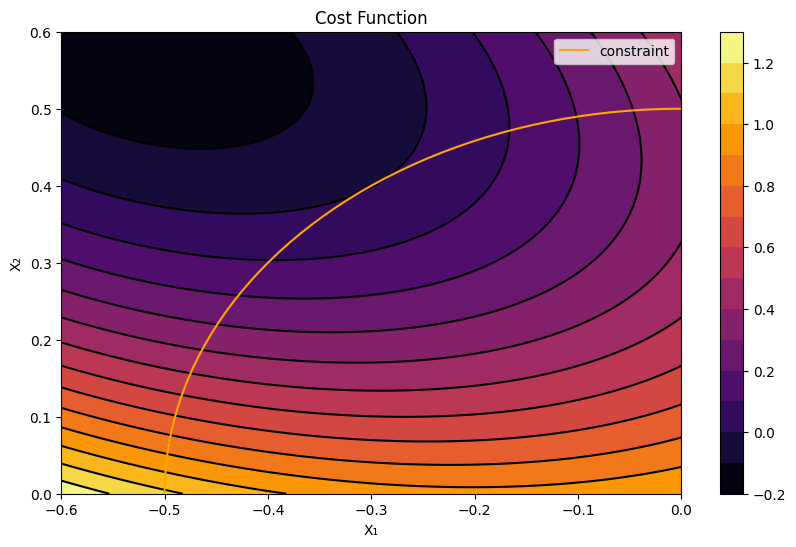

In [4]:
def plotting_cost(x: Array2) -> float:
    Q = np.array([[1.65539, 2.89376], [2.89376, 6.51521]])
    q = np.array([2, -3])
    return 0.5*x@Q@x + q@x + np.exp(-1.3*x[0] + 0.3*x[1]**2)

# Draw contour
xlin = np.linspace(-0.6, 0., num=200)
ylin = np.linspace(0., 0.6, num=200)
xlin, ylin = np.meshgrid(xlin, ylin)
grid = np.stack([xlin, ylin], axis=-1)  # (200, 200, 2)
zlin = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        zlin[i,j] = plotting_cost(grid[i,j])

# Draw constraint
xcirc = np.array([0.5*cos(theta) for theta in np.linspace(0, 2*pi, num=200)])
ycirc = np.array([0.5*sin(theta) for theta in np.linspace(0, 2*pi, num=200)])

plt.figure(figsize=(10,6))
plt.contour(xlin, ylin, zlin, levels=16, colors=['#000','#000'])
plt.contourf(xlin, ylin, zlin, levels=16, cmap='inferno')
plt.plot(xcirc, ycirc, color='orange', label='constraint')
plt.colorbar()
plt.legend()
plt.xlim(xmin=-0.6, xmax=0.)
plt.ylim(ymin=0., ymax=0.6)
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.title('Cost Function')
plt.show()

We will now use Newton's method to solve the following constrained optimization problem. We will write functions for the full Newton Jacobian, as well as the Gauss-Newton Jacobian. 

In [5]:
# we will use Newton's method to solve the constrained optimization problem shown above
def cost(x: Array2) -> float:
    """ f(x) """
    m, batch = x.shape[0], x.shape[1:]
    x = np.reshape(x, (m,-1))

    Q = np.array([[1.65539, 2.89376], [2.89376, 6.51521]])
    q = np.array([2, -3]).reshape((1,2))
    res = 0.5*np.diag(x.T@Q@x) + q@x + np.exp(-1.3*x[0] + 0.3*x[1]**2)

    n = res.shape[0]
    return np.reshape(res, (n,)+batch)

def constraint(x: Array2) -> float:
    """ c(x) = x_1**2 + x_2**2 - 0.5 """
    return np.linalg.norm(x, axis=0) - 0.5 

# HINT: use this if you want to, but you don't have to
def constraint_jacobian(x: Array2) -> Array2:
    # since `constraint` returns a scalar value, ForwardDiff 
    # will only allow us to compute a gradient of this function 
    # (instead of a Jacobian). This means we have two options for
    # computing the Jacobian: Option 1 is to just reshape the gradient
    # into a row vector
    
    # J = reshape(FD.gradient(constraint, x), 1, 2)
    
    # or we can just make the output of constraint an array, 
    #constraint_array(_x) = [constraint(_x)]
    #J = FD.jacobian(constraint_array, x)
    x = x.reshape((len(x),-1))  # (dim_x_vector, num_vectors)
    J = jacobian(constraint, x).df  # (dim_f_output, dim_x_vector, num_vectors)
    
    # assert the jacobian has # rows = # outputs 
    # and # columns = # inputs 
    #assert J.shape == (len(constraint(x)), len(x))

    J = J[...,0]  # num_vectors would be 1
    assert J.shape == (len(x),)
    
    return J

def kkt_conditions(z: Array3) -> Array3:
    # TODO: return the KKT conditions
    x = z[:2]
    x = x.reshape((len(x),-1))  # (dim_x_vector, num_vectors)
    lamb = z[2]

    # TODO: return the stationarity condition for the cost function
    # and the primal feasibility
    A = constraint_jacobian(x)
    cost_j = jacobian(cost, x).df[0,:,0]  # (dim_x_vector,)
    cx = constraint(x)  # (dim_f_output,)

    ret = np.concatenate([cost_j + A*lamb, cx])  # (dim_x_vector+dim_f_output,) -> (3,)
    return ret

def fn_kkt_jac(z: Array3) -> Array3x3:
    # TODO: return full Newton Jacobian of kkt conditions wrt z
    x = z[:2]
    x = x.reshape((len(x),-1))  # (dim_x_vector, num_vectors)
    lamb = z[2]
    
    # TODO: return full Newton jacobian with a 1e-3 regularizer
    _lag: Callable[[Array2], float] = lambda _x: cost(_x) + lamb*constraint(_x)
    A = jacobian(constraint, x).df[:,0]  # (dim_x_vector,)
    H = hessian(_lag, x).ddf[0,:,:,0]  # (dim_x_vector, dim_x_vector)
    rho = 1e-3

    # H + rho*np.eye(2)  A
    # A  -rho
    R1 = np.concatenate([H + rho*np.eye(2), A.reshape((len(A),-1))], axis=1)  # (dim_x_vector, dim_x_vector+1)
    R2 = np.concatenate([A.reshape((-1,len(A))), (-rho*np.eye(1))], axis=1)  # (1, dim_x_vector+1)
    ret = np.concatenate([R1, R2], axis=0)

    return ret

def gn_kkt_jac(z: Array3) -> Array3x3:
    # TODO: return Gauss-Newton Jacobian of kkt conditions wrt z 
    x = z[:2]
    x = x.reshape((len(x),-1))  # (dim_x_vector, num_vectors)
    lamb = z[2]

    # TODO: return Gauss-Newton jacobian with a 1e-3 regularizer
    A = jacobian(constraint, x).df[:,0]  # (dim_x_vector,)
    H = hessian(cost, x).ddf[0,:,:,0]  # (dim_x_vector, dim_x_vector)
    rho = 1e-3
    R1 = np.concatenate([H + rho*np.eye(2), A.reshape((len(A),-1))], axis=1)  # (dim_x_vector, dim_x_vector+1)
    R2 = np.concatenate([A.reshape((-1,len(A))), (-rho*np.eye(1))], axis=1)  # (1, dim_x_vector+1)
    ret = np.concatenate([R1, R2], axis=0)

    return ret

In [6]:
#@testset "Test Jacobians" begin 
    
# first we check the regularizer 
z = np.random.normal(size=3)
J_fn = fn_kkt_jac(z)
J_gn = gn_kkt_jac(z)

# check what should/shouldn't be the same between 
assert np.linalg.norm(J_fn[:2, :2] - J_gn[:2, :2]) > 1e-10
assert abs(J_fn[2, 2] + 1e-3) < 1e-10
assert abs(J_gn[2, 2] + 1e-3) < 1e-10
assert np.linalg.norm(J_fn[:2, 2] - J_gn[:2, 2]) < 1e-10
assert np.linalg.norm(J_fn[2, :2] - J_gn[2, :2]) < 1e-10

iter: 0    |r|: 1.7188450769812922   α: 1.0 

iter: 1    |r|: 0.8150495962038627   α: 1.0 

iter: 2    |r|: 0.025448943702559554   α: 1.0 



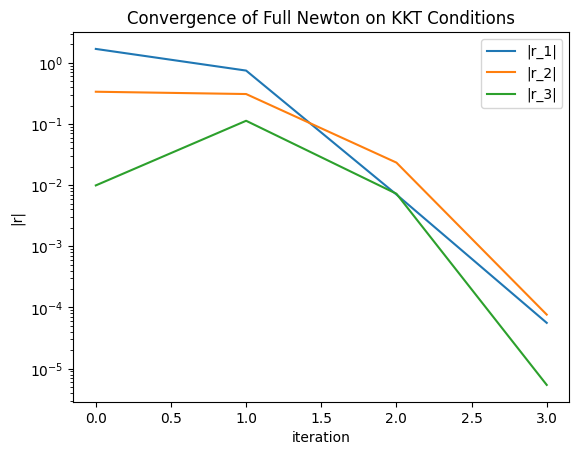

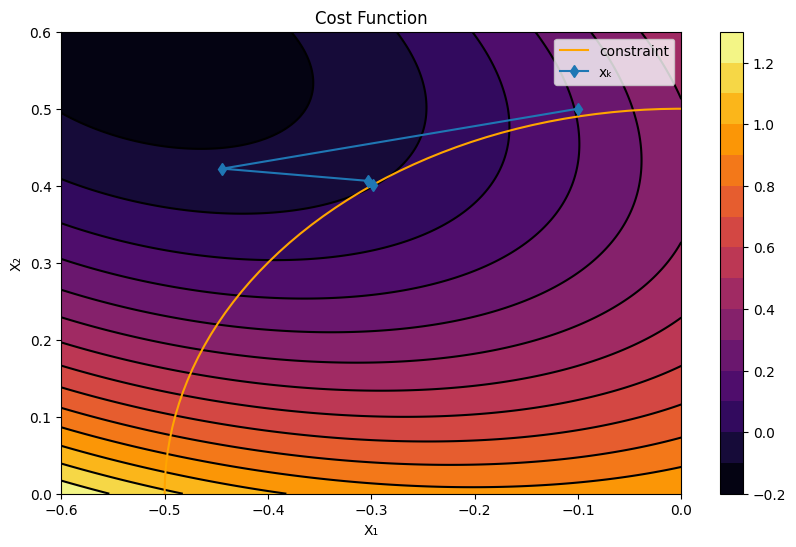

In [7]:
#@testset "Full Newton" begin 

z0 = np.array([-.1, .5, 0])  # initial guess
merit_fx = lambda _z: np.linalg.norm(kkt_conditions(_z))  # simple merit function
Z = newtons_method(z0, kkt_conditions, fn_kkt_jac, merit_fx, tol=1e-4, max_iters=100, verbose=True)
R = np.zeros_like(Z)
for i in range(len(Z)):
    R[i] = kkt_conditions(Z[i])

# make sure we converged on a solution to the KKT conditions 
assert np.linalg.norm(kkt_conditions(Z[-1])) < 1e-4
assert len(R) < 6

# ------------------------plotting stuff------------------------
Rp = np.array([[abs(R[i, ii]) + 1e-15 for i in range(R.shape[0])] for ii in range(R.shape[1])])  # this gets abs of each term at each iteration

#yticks = np.array([1.0*10.0**(-x) for x in np.arange(15, -2, -1)])
plt.figure()
plt.title('Convergence of Full Newton on KKT Conditions')
plt.plot(Rp[0], label='|r_1|')
plt.plot(Rp[1], label='|r_2|')
plt.plot(Rp[2], label='|r_3|')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('|r|')
plt.legend()
plt.show()


# Draw constraint
xcirc = np.array([0.5*cos(theta) for theta in np.linspace(0, 2*pi, num=200)])
ycirc = np.array([0.5*sin(theta) for theta in np.linspace(0, 2*pi, num=200)])

z1_hist = np.array([z[0] for z in Z])
z2_hist = np.array([z[1] for z in Z])

plt.figure(figsize=(10,6))
plt.contour(xlin, ylin, zlin, levels=16, colors=['#000','#000'])
plt.contourf(xlin, ylin, zlin, levels=16, cmap='inferno')
plt.plot(xcirc, ycirc, color='orange', label='constraint')
plt.plot(z1_hist, z2_hist, marker='d', label='xₖ')
plt.colorbar()
plt.legend()
plt.xlim(xmin=-0.6, xmax=0.)
plt.ylim(ymin=0., ymax=0.6)
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.title('Cost Function')
plt.show()
# ------------------------plotting stuff------------------------


iter: 0    |r|: 1.7188450769812922   α: 1.0 

iter: 1    |r|: 0.8150495962038627   α: 1.0 

iter: 2    |r|: 0.19186516708106732   α: 1.0 

iter: 3    |r|: 0.046634905530360295   α: 1.0 

iter: 4    |r|: 0.01332977842931696   α: 1.0 

iter: 5    |r|: 0.003771401357797349   α: 1.0 

iter: 6    |r|: 0.0010711650547622536   α: 1.0 

iter: 7    |r|: 0.0003039221070649298   α: 1.0 



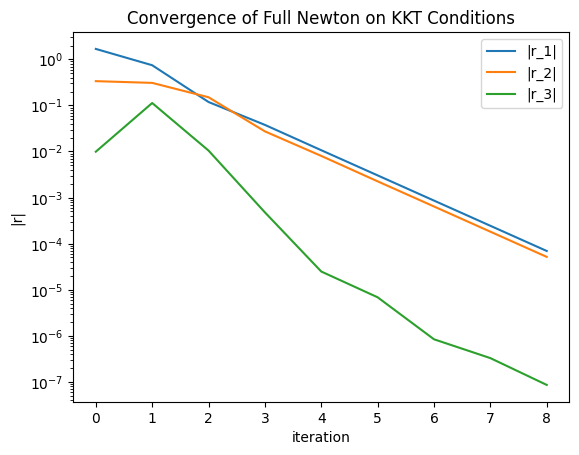

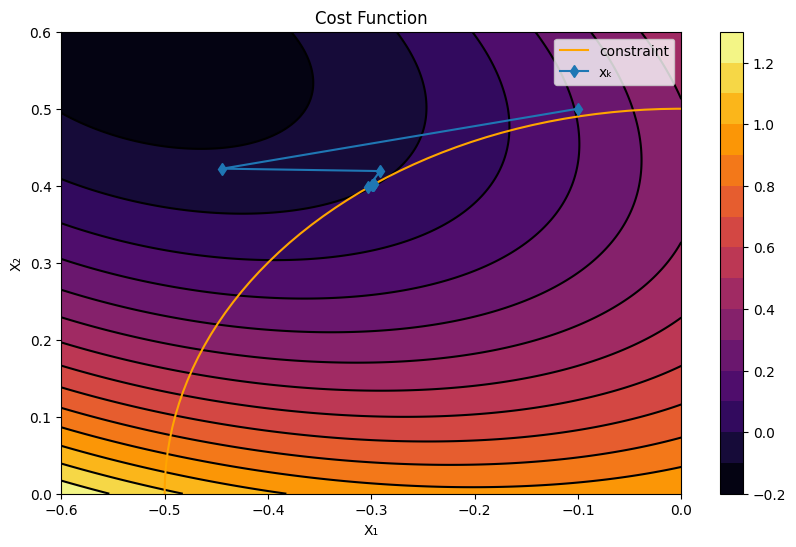

In [8]:
#@testset "Gauss-Newton" begin 
    
    
z0 = np.array([-.1, .5, 0])  # initial guess
merit_fx = lambda _z: np.linalg.norm(kkt_conditions(_z))  # simple merit function

# the only difference in this block vs the previous is `gn_kkt_jac` instead of `fn_kkt_jac`
Z = newtons_method(z0, kkt_conditions, gn_kkt_jac, merit_fx, tol=1e-4, max_iters=100, verbose=True)
R = np.zeros_like(Z)
for i in range(len(Z)):
    R[i] = kkt_conditions(Z[i])

# make sure we converged on a solution to the KKT conditions 
assert np.linalg.norm(kkt_conditions(Z[-1])) < 1e-4
assert len(R) < 10


# ------------------------plotting stuff------------------------
Rp = np.array([[abs(R[i, ii]) + 1e-15 for i in range(R.shape[0])] for ii in range(R.shape[1])])  # this gets abs of each term at each iteration

plt.figure()
plt.title('Convergence of Full Newton on KKT Conditions')
plt.plot(Rp[0], label='|r_1|')
plt.plot(Rp[1], label='|r_2|')
plt.plot(Rp[2], label='|r_3|')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('|r|')
plt.legend()
plt.show()


# Draw constraint
xcirc = np.array([0.5*cos(theta) for theta in np.linspace(0, 2*pi, num=200)])
ycirc = np.array([0.5*sin(theta) for theta in np.linspace(0, 2*pi, num=200)])

z1_hist = np.array([z[0] for z in Z])
z2_hist = np.array([z[1] for z in Z])

plt.figure(figsize=(10,6))
plt.contour(xlin, ylin, zlin, levels=16, colors=['#000','#000'])
plt.contourf(xlin, ylin, zlin, levels=16, cmap='inferno')
plt.plot(xcirc, ycirc, color='orange', label='constraint')
plt.plot(z1_hist, z2_hist, marker='d', label='xₖ')
plt.colorbar()
plt.legend()
plt.xlim(xmin=-0.6, xmax=0.)
plt.ylim(ymin=0., ymax=0.6)
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.title('Cost Function')
plt.show()
# ------------------------plotting stuff------------------------

## Part B (10 pts): Balance a quadruped
Now we are going to solve for the control input $u \in \mathbb{R}^{12}$, and state $x \in \mathbb{R}^{30}$, such that the quadruped is balancing up on one leg at an equilibrium point. First, let's load in a dynamics model from `quadruped.jl`, where 

$ \dot{x} = f(x,u) =$ `dynamics(model, x, u)`



In [ ]:
# include the functions from quadruped.jl
include(joinpath(@__DIR__, "quadruped.jl"))

# this loads in our continuous time dynamics function xdot = dynamics(model, x, u)

let's load in a model and display the rough "guess" configuration that we are going for:

In [ ]:
# --------these three are global variables------------
model = UnitreeA1() # contains all the model properties for the quadruped
mvis = initialize_visualizer(model) # visualizer 
const x_guess = initial_state(model) # our guess state for balancing
# ----------------------------------------------------

set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
render(mvis)

Now, we are going to solve for the state and control that get us an equilibrium (balancing) on just one leg. We are going to do this by solving the following optimization problem:

$$ \begin{align} \min_{x,u} \quad & \frac{1}{2}(x - x_{guess})^T(x - x_{guess}) + \frac{1}{2}10^{-3} u^Tu \\ 
 \text{st} \quad & \dot{x} = f(x,u) = 0 
 \end{align}$$
 
 Where our primal variables are $x \in \mathbb{R}^{30}$ and $u \in \mathbb{R}^{12}$, that we can stack up in a new variable $y = [x^T, u^T]^T \in \mathbb{R}^{42}$. We have a constraint $\dot{x} = f(x,u) = 0$, which will ensure the resulting configuration is an equilibrium. This constraint is enforced with a dual variable $\lambda \in \mathbb{R}^{30}$. We are now ready to use Newton's method to solve this equality constrained optimization problem, where we will solve for a variable $z = [y^T, \lambda^T]^T \in \mathbb{R}^{72}$.
 
 In this next section, you should fill out `quadruped_kkt(z)` with the KKT conditions for this optimization problem, given the constraint is that `dynamics(model, x, u) = zeros(30)`. When forming the Jacobian of the KKT conditions, use the Gauss-Newton approximation for the hessian of the Lagrangian (see example above if you're having trouble with this).

In [ ]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:30 
const idx_u = 31:42
const idx_c = 43:72

# I like stacking up all the primal variables in y, where y = [x;u]
# Newton's method will solve for z = [x;u;λ], or z = [y;λ]

function quadruped_cost(y::Vector)
    # cost function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return cost 
    error("quadruped cost not implemented")
    return 0.0
end
function quadruped_constraint(y::Vector)::Vector
    # constraint function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return constraint
    error("quadruped constraint not implemented")
    return 0*y
end
function quadruped_kkt(z::Vector)::Vector
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return the KKT conditions 
    error("quadruped kkt not implemented")
    return 0*z
end

function quadruped_kkt_jac(z::Vector)::Matrix
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return Gauss-Newton Jacobian with a regularizer (try 1e-3,1e-4,1e-5,1e-6)
    # and use whatever regularizer works for you
    error("quadruped kkt jac not implemented")
    return zeros(length(z), length(z))
end

In [ ]:
function quadruped_merit(z)
    # merit function for the quadruped problem 
    @assert length(z) == 72 
    r = quadruped_kkt(z)
    return norm(r[1:42]) + 1e4*norm(r[43:end])
end

@testset "quadruped standing" begin
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = true, max_iters = 50)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    R = norm.(quadruped_kkt.(Z))
    
    display(plot(1:length(R), R, yaxis=:log,xlabel = "iteration", ylabel = "|r|"))
    
    @test R[end] < 1e-6
    @test length(Z) < 25
    
    x,u = Z[end][idx_x], Z[end][idx_u]
    
    @test norm(dynamics(model, x, u)) < 1e-6
    
end

In [ ]:
let
    
    # let's visualize the balancing position we found
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = false, max_iters = 50)
    # visualizer 
    mvis = initialize_visualizer(model)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    render(mvis)
    
    
end